# File Description

This notebook contains the most up-to-date version of the pilot model for total water level on Tarawa, currently for only two locations (one lagoon side and one ocean side).

Currently needs work:
- Incorporating MEI into network
- Adjusting the binning of the MSL distributions to account for future SLR
- Adding SLR projections as evidence option

# File Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
import os
import json
from datetime import datetime
import pysmile
import pysmile_license
import sys
import json
sys.path.append('/src/python_classes')
import rpy2
# os.environ['R_HOME'] = 'C:\ProgramData\Anaconda3\Lib\R'
# %load_ext rpy2.ipython
!jupyter nbextension enable --py --sys-prefix ipyleaflet
from ipywidgets import interact, interactive, fixed, interact_manual
from ipyleaflet import *
import ipywidgets as widgets
from matplotlib.animation import FuncAnimation
import geojson
import folium
from colormap import rgb2hex
import rpy2
os.environ['R_HOME'] = '/lib/R'
%load_ext rpy2.ipython
from folium.plugins import FloatImage
from shapely import geometry

from BNModel import BNModel

from preprocessing_all_points import *
from preprocessing_points_spatially import *

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [3]:
# ### set location of file storage
# folder = 'BN_antonio_data'
# try:
#     os.makedirs(folder)
# except FileExistsError:
#     pass

# Data Prep

## import the dataframe

In [4]:
df_shoreline_change = pd.read_csv('wave_lag_vars.csv')

In [40]:
df_shoreline_change

,proxy,islet_id,atoll,beginning_year,end_year,intersect_distance,x_avg,y_avg,m_transect,c_transect,...,NE_low_freq,NE_high_freq,ES_low_freq,ES_high_freq,SW_low_freq,SW_high_freq,WN_low_freq,WN_high_freq,lag_intersect_distance,lag_intersect_distance_surroundings
0,TOB,1,Nanumea,1984,2003,0.000115,176.117853,-5.675067,0.392769,-74.848763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000005,-0.000013
1,TOB,1,Nanumea,1984,2003,0.000030,176.118034,-5.675653,0.223871,-45.103396,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000047,-0.000037
2,TOB,1,Nanumea,1984,2003,0.000088,176.118285,-5.676200,0.739207,-135.863984,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000062,-0.000042
3,TOB,1,Nanumea,1984,2003,0.000220,176.118729,-5.676621,1.513884,-272.300006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000138,-0.000024
4,TOB,1,Nanumea,1984,2003,0.000413,176.119240,-5.676777,-18.975837,3336.333241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000218,-0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27820,WM,1,Nanumaga,2019,2020,-0.000093,176.324837,-6.277834,0.379214,-73.142691,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000040,-0.000042
27821,WM,1,Nanumaga,2019,2020,-0.000045,176.325050,-6.278432,0.331075,-64.655184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000026,-0.000036
27822,WM,1,Nanumaga,2019,2020,-0.000032,176.325252,-6.279035,0.341863,-66.558135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000022,-0.000034
27823,WM,1,Nanumaga,2019,2020,-0.000018,176.325473,-6.279631,0.397512,-76.371111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000017,-0.000038


## Replace the NAN with zero

In [5]:
df_shoreline_change.replace(np.nan,0,inplace=True)

## Changing Column names

In [6]:
df_shoreline_change.columns = \
    ['lon',
     'lat',
     'proxy',
     'islet_id',
     'atoll',
     'beginning_year',
     'end_year',
     'intersect_distance',
     'x_avg',
     'y_avg',
     'm_transect',
     'c_transect',
     'shoreline_direction',
     'avg_slope_change',
     "NE_low_freq",
     "NE_high_freq",
     "ES_low_freq",
     "ES_high_freq",
     "SW_low_freq",
     "SW_high_freq",
     "WN_low_freq",
     "WN_high_freq",
     'lag_intersect_distance',
     'lag_intersect_distance_surroundings']

## Format the data

In [7]:
df_shoreline_change.loc[df_shoreline_change.avg_slope_change==-0,'avg_slope_change']=0
df_shoreline_change['avg_slope_change'] = ['angle'+str(x).replace('-','negative').replace('.0','') for x in df_shoreline_change.avg_slope_change]

## Remove the zeros

In [8]:
df_shoreline_change_original = df_shoreline_change.copy()

df_shoreline_change_reduced = df_shoreline_change[\
      (np.abs(df_shoreline_change.intersect_distance)<0.03) # np.abs(df_shoreline_change.intersect_distance)>=0.001)&
                                                 ].reset_index(drop=True)

In [9]:
df_shoreline_change_reduced

,lon,lat,proxy,islet_id,atoll,beginning_year,end_year,intersect_distance,x_avg,y_avg,...,NE_low_freq,NE_high_freq,ES_low_freq,ES_high_freq,SW_low_freq,SW_high_freq,WN_low_freq,WN_high_freq,lag_intersect_distance,lag_intersect_distance_surroundings
0,176.117738,-5.674775,TOB,1,Nanumea,1984,2003,0.000115,176.117853,-5.675067,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000005,-0.000013
1,176.117968,-5.675359,TOB,1,Nanumea,1984,2003,0.000030,176.118034,-5.675653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000047,-0.000037
2,176.118099,-5.675948,TOB,1,Nanumea,1984,2003,0.000088,176.118285,-5.676200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000062,-0.000042
3,176.118471,-5.676451,TOB,1,Nanumea,1984,2003,0.000220,176.118729,-5.676621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000138,-0.000024
4,176.118986,-5.676791,TOB,1,Nanumea,1984,2003,0.000413,176.119240,-5.676777,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000218,-0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27820,176.324724,-6.277536,WM,1,Nanumaga,2019,2020,-0.000093,176.324837,-6.277834,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000040,-0.000042
27821,176.324950,-6.278131,WM,1,Nanumaga,2019,2020,-0.000045,176.325050,-6.278432,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000026,-0.000036
27822,176.325149,-6.278734,WM,1,Nanumaga,2019,2020,-0.000032,176.325252,-6.279035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000022,-0.000034
27823,176.325355,-6.279336,WM,1,Nanumaga,2019,2020,-0.000018,176.325473,-6.279631,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000017,-0.000038


(array([1.1000e+01, 2.6000e+01, 2.7735e+04, 4.1000e+01, 1.2000e+01]),
 array([-0.02675858, -0.01582614, -0.00489369,  0.00603875,  0.01697119,
         0.02790363]),
 <BarContainer object of 5 artists>)

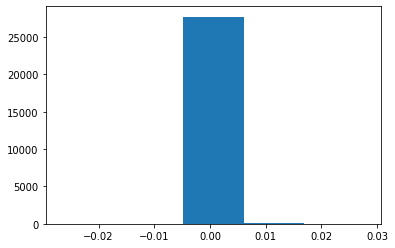

In [10]:
plt.hist(df_shoreline_change_reduced.intersect_distance,bins=5)

In [11]:
df_shoreline_change = df_shoreline_change_reduced.copy()

In [12]:
df_shoreline_change.drop(['lon','lat'],axis=1,inplace=True)

# Create Angle of Incidence Variable

In [13]:
# df_shoreline_change.lab_intersect_distance


## Create Variable Dictionary

In [14]:
shoreline_change_model_dict = {
   'variables':{
       'proxy':{
            'label':'Shoreline Proxy',
            'child_nodes':['intersect_distance'],
            'bins':list(np.unique(df_shoreline_change.proxy))
        },
        'shoreline_direction':{
            'label':'Direction of shoreline (degrees)',
            'discretisation':{
                'n_bins':4,
                'strategy':'kmeans',
                'bin_names':['NE','SE','SW','NW'] # I think these labels are wrong... because we start at -180
            },
            'child_nodes':['intersect_distance']
        },
        'avg_slope_change':{
            'label':'Angle between adjacent shoreline segments (degrees)',
            'child_nodes':['intersect_distance'],
            'bins':list(np.unique(df_shoreline_change.avg_slope_change))
        },
        'intersect_distance':{
            'label':'Distance shoreline has moved',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':[]
        },
#         "NE_low_freq":{
#             'label':"(0.033, 0.1997, 'NE', 'mean')",
#             'discretisation':{
#                 'n_bins':3,
#                 'strategy':'kmeans',
#                 'bin_names':['Low','Mid','High']
#             },
#             'child_nodes':['intersect_distance']
#         },
        "NE_high_freq":{
            'label':"(0.1997, 1.0, 'NE', 'mean')",
            'discretisation':{
                'n_bins':3,
                'strategy':'kmeans',
                'bin_names':['Low','Mid','High']
            },
            'child_nodes':['intersect_distance']
        },
#         "ES_low_freq":{
#             'label':"(0.033, 0.1997, 'ES', 'mean')",
#             'discretisation':{
#                 'n_bins':3,
#                 'strategy':'kmeans',
#                 'bin_names':['Low','Mid','High']
#             },
#             'child_nodes':['intersect_distance']
#         },
        "ES_high_freq":{
            'label':"(0.1997, 1.0, 'ES', 'mean')",
            'discretisation':{
                'n_bins':3,
                'strategy':'kmeans',
                'bin_names':['Low','Mid','High']
            },
            'child_nodes':['intersect_distance']
        },
#         "SW_low_freq":{
#             'label':"(0.033, 0.1997, 'SW', 'mean')",
#             'discretisation':{
#                 'n_bins':3,
#                 'strategy':'kmeans',
#                 'bin_names':['Low','Mid','High']
#             },
#             'child_nodes':['intersect_distance']
#         },
        "SW_high_freq":{
            'label':"(0.1997, 1.0, 'SW', 'mean')",
            'discretisation':{
                'n_bins':3,
                'strategy':'kmeans',
                'bin_names':['Low','Mid','High']
            },
            'child_nodes':['intersect_distance']
        },
#         "WN_low_freq":{
#             'label':"(0.033, 0.1997, 'WN', 'mean')",
#             'discretisation':{
#                 'n_bins':3,
#                 'strategy':'kmeans',
#                 'bin_names':['Low','Mid','High']
#             },
#             'child_nodes':['intersect_distance']
#         },
        "WN_high_freq":{
            'label':"(0.1997, 1.0, 'WN', 'mean')",
            'discretisation':{
                'n_bins':3,
                'strategy':'kmeans',
                'bin_names':['Low','Mid','High']
            },
            'child_nodes':['intersect_distance']
        }
#         'Tide':{
#             'label':'Tide',
#             'discretisation':{
#                 'n_bins':5,
#                 'strategy':'kmeans',
#                 'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
#             },
#             'child_nodes':['TWL']
#         },
#         'TWL':{
#             'label':'Total water level',
#             'discretisation':{
#                 'n_bins':7,
#                 'strategy':'binned',
#                 'bin_names':['VeryLow','Low','LowMid','Mid','MidHigh','High','VeryHigh'],
#                 'bin_edges':np.arange(-1,3.0,0.5)
#             },
#             'child_nodes':[]
#         },
#         'TWL_less_Tide':{
#             'label':'Total water level less tide',
#             'discretisation':{
#                 'n_bins':5,
#                 'strategy':'kmeans',
#                 'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
#             },
#             'child_nodes':['TWL']
#         },
#         'reef_width':{
#             'label':'Reef width',
#             'discretisation':{
#                 'n_bins':5,
#                 'strategy':'kmeans',
#                 'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
#             },
#             'child_nodes':['TWL_less_Tide']
#         },
#         'reef_depth':{
#             'label':'Reef depth',
#             'discretisation':{
#                 'n_bins':5,
#                 'strategy':'kmeans',
#                 'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
#             },
#             'child_nodes':['TWL_less_Tide']
#         },
#         'forereef_slope':{
#             'label':'Fore reef slope',
#             'discretisation':{
#                 'n_bins':5,
#                 'strategy':'kmeans',
#                 'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
#             },
#             'child_nodes':['TWL_less_Tide']
#         },
#         'shore_dir':{
#             'label':'Shoreline direction',
#             'discretisation':{
#                 'n_bins':3,
#                 'strategy':'kmeans',
#                 'bin_names':['NE','S','NW']
#             },
#             'child_nodes':['TWL_less_Tide']
#         } 
   },
    'training_frac':0.8,
    'bootstrap_reps':1
}

In [15]:
# Create a dictionary of the data for the variables in the model dict
df_temp = df_shoreline_change[list(shoreline_change_model_dict['variables'].keys())]
shoreline_change_data_dict = {k:np.array(v) for k,v in df_temp.items()}

In [16]:
list(np.unique(df_shoreline_change.avg_slope_change))

['angle0',
 'angle135',
 'angle180',
 'angle45',
 'angle90',
 'anglenegative135',
 'anglenegative180',
 'anglenegative45',
 'anglenegative90']

In [17]:
shoreline_change_data_dict['avg_slope_change']

array(['anglenegative45', 'angle0', 'angle45', ..., 'angle0', 'angle0',
       'angle0'], dtype=object)

## Bootstrapping the data

In [18]:
# Bootstrap the data, and add it to the model_dict
shoreline_change_model_dict = BNModel().bootstrap_data(shoreline_change_model_dict,shoreline_change_data_dict,df_shoreline_change)

## Discretise the data

In [19]:
# Discretise the data
shoreline_change_file_label = "ocean"

shoreline_change_model_dict = BNModel().discretiser(shoreline_change_model_dict,[])

proxy
avg_slope_change


## Look at the discretised data

In [20]:
test = pd.DataFrame.from_dict(\
   {key:var_dict['training_data'][0] for key,var_dict in shoreline_change_model_dict['variables'].items()}
                              )
test

,proxy,shoreline_direction,avg_slope_change,intersect_distance,NE_high_freq,ES_high_freq,SW_high_freq,WN_high_freq
0,TOB,NE,anglenegative45,Mid,Low,Low,Low,Low
1,TOB,NE,angle0,Mid,Low,Low,Low,Low
2,TOB,NE,angle45,Mid,Low,Low,Low,Low
3,TOB,NW,angle135,Mid,Low,Low,Low,Low
4,TOB,NE,angle135,Mid,Low,Low,Low,Low
...,...,...,...,...,...,...,...,...
22255,WM,NE,anglenegative45,Mid,Low,Low,Low,Low
22256,WM,NE,angle0,Mid,Low,Low,Low,Low
22257,WM,NE,angle0,Mid,Low,Low,Low,Low
22258,WM,NE,angle0,Mid,Low,Low,Low,Low


## Save the data

In [21]:
BNModel().save_dataset(shoreline_change_model_dict,shoreline_change_file_label)

# Create BN Model

In [22]:
shoreline_change_model_dict = BNModel().create_SM(shoreline_change_model_dict,shoreline_change_file_label)

## Look at bins of intersection_distance

## View Conditional Probability tables

In [23]:
# Get conditional probs tables
df_CPT_MSL = BNModel().get_conditional_prob_table(shoreline_change_model_dict,'intersect_distance')

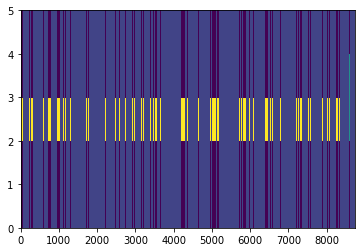

In [24]:
df_CPT_MSL = df_CPT_MSL.loc[['VeryLow','Low','Mid','High','VeryHigh']]

plt.pcolor(df_CPT_MSL)

In [25]:
df_CPT_MSL

proxy                  TOB                                               ...  \
shoreline_direction     NE                                               ...   
avg_slope_change    angle0                                               ...   
NE_high_freq           Low                                               ...   
ES_high_freq           Low                                          Mid  ...   
SW_high_freq           Low            Mid           High            Low  ...   
WN_high_freq           Low  Mid High  Low  Mid High  Low  Mid High  Low  ...   
intersect_distance                                                       ...   
VeryLow                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.2  ...   
Low                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.2  ...   
Mid                    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.2  0.2  ...   
High                   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.2  ...   
VeryHigh               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.2  ...   

proxy                            WM                                          \
shoreline_direction              NW                                           
avg_slope_change    anglenegative90                                           
NE_high_freq                   High                                           
ES_high_freq                    Mid High                                      
SW_high_freq                   High  Low            Mid           High        
WN_high_freq                   High  Low  Mid High  Low  Mid High  Low  Mid   
intersect_distance                                                            
VeryLow                         0.2  0.0  0.2  0.2  0.2  0.2  0.2  0.2  0.2   
Low                             0.2  0.0  0.2  0.2  0.2  0.2  0.2  0.2  0.2   
Mid                             0.2  1.0  0.2  0.2  0.2  0.2  0.2  0.2  0.2   
High                            0.2  0.0  0.2  0.2  0.2  0.2  0.2  0.2  0.2   
VeryHigh                        0.2  0.0  0.2  0.2  0.2  0.2  0.2  0.2  0.2   

proxy                     
shoreline_direction       
avg_slope_change          
NE_high_freq              
ES_high_freq              
SW_high_freq              
WN_high_freq        High  
intersect_distance        
VeryLow              0.2  
Low                  0.2  
Mid                  0.2  
High                 0.2  
VeryHigh             0.2  

[5 rows x 8748 columns]

In [26]:
np.unique(df_CPT_MSL)

array([0.        , 0.0041841 , 0.0078125 , 0.01098901, 0.01219512,
       0.01408451, 0.01754386, 0.02150538, 0.02564103, 0.02631579,
       0.02702703, 0.02857143, 0.02941176, 0.03125   , 0.03703704,
       0.03773585, 0.03846154, 0.04347826, 0.04477612, 0.04761905,
       0.05      , 0.05882353, 0.06666667, 0.07142857, 0.07692308,
       0.08333333, 0.0952381 , 0.1       , 0.11111111, 0.125     ,
       0.14285714, 0.16666667, 0.2       , 0.22222222, 0.25      ,
       0.33333333, 0.5       , 0.6       , 0.66666667, 0.71428571,
       0.75      , 0.77777778, 0.83333333, 0.85714286, 0.875     ,
       0.88235294, 0.88461538, 0.88888889, 0.9       , 0.9047619 ,
       0.91666667, 0.92307692, 0.92857143, 0.93333333, 0.94117647,
       0.94871795, 0.95      , 0.95238095, 0.95522388, 0.95652174,
       0.96226415, 0.96875   , 0.97058824, 0.97142857, 0.97297297,
       0.97368421, 0.9765625 , 0.97802198, 0.97849462, 0.98245614,
       0.98591549, 0.98780488, 0.9916318 , 1.        , 1.     

# Set Evidence

In [27]:
shoreline_change_evidence_dict = {
    'proxy':[1,0,0],
}

In [28]:
shoreline_change_model_dict = BNModel().add_evidence_to_dict(shoreline_change_model_dict,shoreline_change_evidence_dict)

# Update beliefs based on evidence

In [29]:
# Set evidence and get beliefs
shoreline_change_model_dict = BNModel().update_evidence(shoreline_change_model_dict)

# BN Visualisation

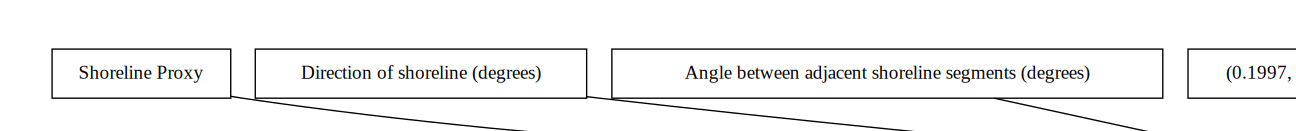

In [30]:

# Set up graph
graph_shoreline_change = BNModel().create_BN_graph()

# Create nodes of the graph
graph_shoreline_change,shoreline_change_model_dict = BNModel().create_nodes(graph_shoreline_change,shoreline_change_model_dict,0)

# Create arcs between nodesb
graph_shoreline_change = BNModel().create_arcs(graph_shoreline_change,shoreline_change_model_dict)

# Save as dot file
graph_shoreline_change.render(filename='graph_ocean',format='png')

# Plot the graph
graph_shoreline_change

# Model Validation

{(0, 'VeryLow'): nan, (0, 'Low'): 0.0, (0, 'Mid'): 0.985945945945946, (0, 'High'): 0.0, (0, 'VeryHigh'): 0.0}


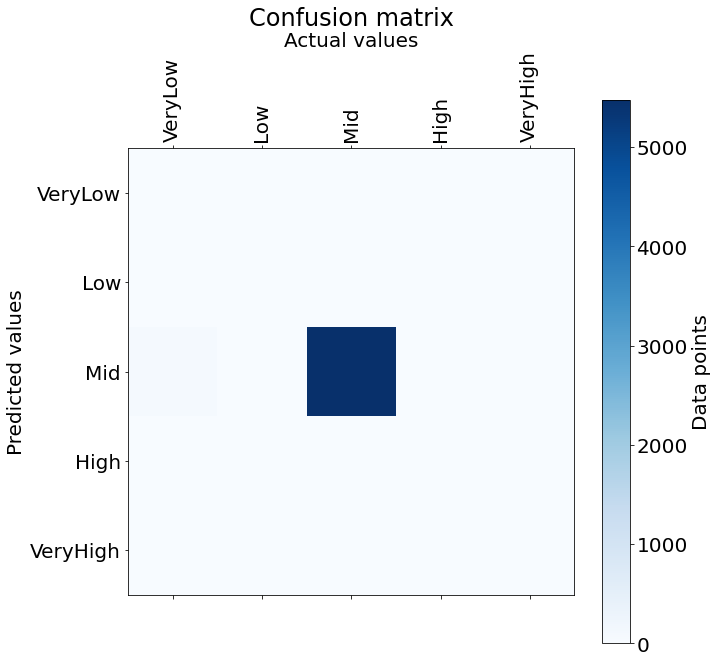

In [31]:

shoreline_change_acc_dict = BNModel().get_accuracies(shoreline_change_model_dict,"intersect_distance")

print(shoreline_change_acc_dict)

fig, ax = BNModel().confusion_matrix(shoreline_change_model_dict,"intersect_distance",0)

plt.show()

# Visualise the Change in shoreline

In [32]:
# for key,group in df_visualisation.groupby(['beginning_year','end_year']):
#     print(group)
#     asdf

In [33]:
def bin_locator(value,bin_edges):
    '''
    function used for determining the index of the appropriate bin for a numerical value.
    '''
    i=0
    for edge_1,edge_2 in zip(bin_edges[:-1],bin_edges[1:]):
        if (value>edge_1)&(value<=edge_2):
            loc_bin = i
        else:
            i+=1
            continue

    if value<=bin_edges[0]:
        loc_bin = 0

    if value>=bin_edges[-1]:
        loc_bin = len(bin_edges)-2

    return(loc_bin)

In [34]:
atoll = 'Nanumea'
proxy = 'WM'

# Get subset of dataframe
df_visualisation = df_shoreline_change_original.copy()
df_visualisation = df_visualisation[
    (df_visualisation.proxy==proxy)&\
    (df_visualisation.atoll==atoll)&\
    (df_visualisation.islet_id==1)]

# Get dictionary of just bins
bin_pt1 = [key for key,item in shoreline_change_model_dict['variables'].items() if 'bins' in item]
bin_pt2 = [key for key,item in shoreline_change_model_dict['variables'].items() if 'discretisation' in item]
bin_pt2.remove('intersect_distance') # remove intersect distance because this is what we are solving for 

for i in df_visualisation.index:
    evidence_to_set = {key:df_visualisation.loc[i,key] for key,item in shoreline_change_model_dict['variables'].items()}

    evidence_dict = {}

    for key in bin_pt2:
        bin_edges = shoreline_change_model_dict['variables'][key]['bin_edges'][0]
        evidence = evidence_to_set[key]
        var_bin = bin_locator(evidence,bin_edges)
        evidence_array = [0]*(len(bin_edges)-1)
        evidence_array[var_bin] = 1

        evidence_dict.update({
            key:evidence_array
        })

    for key in bin_pt1:
        evidence = evidence_to_set[key]
        if evidence==-0:
            evidence = float(0)
        evidence = str(evidence)
        bins = shoreline_change_model_dict['variables'][key]['bins']
        evidence_array = [1 if evidence==x else 0 for x in bins]

        evidence_dict.update({
            key:evidence_array
        })

    # Add evidence to model dict
    model_location_dict = BNModel().add_evidence_to_dict(shoreline_change_model_dict,evidence_dict)

    # Set evidence and get beliefs
    model_location_dict = BNModel().update_evidence(model_location_dict)

    # get the resulting probabilities
    resulting_probs = model_location_dict['variables']['intersect_distance']['resulting_probs'][0]

    # get bin information, and calculate the most likely change in distance of the shoreline according to the BN
    bin_edges = model_location_dict['variables']['intersect_distance']['bin_edges'][0]
    training_data = model_location_dict['variables']['intersect_distance']['training_data_preprocessed'][0] # Get the training data
    bin_means = [] # For each bin, get the mean of the training data
    for bin_min,bin_max in zip(bin_edges[:-1],bin_edges[1:]):
        bin_means.append(np.mean(training_data[(training_data<bin_max)&(training_data>bin_min)]))    
    df_probs = pd.DataFrame.from_dict(resulting_probs,orient='index')
    df_probs.columns = ['probs']
    df_probs['bin_means'] = bin_means
    max_probs_int_dist = df_probs.loc[(df_probs.probs==np.max(df_probs.probs)),'bin_means']
    max_prob_int_dist = np.mean(max_probs_int_dist)

    df_visualisation.loc[i,'shoreline_movement'] = max_prob_int_dist


# Get constants for quadratic equation
a = df_visualisation.m_transect**2+1
b = -2*df_visualisation.y_avg*df_visualisation.m_transect+2*df_visualisation.c_transect*df_visualisation.m_transect-2*df_visualisation.x_avg
c = df_visualisation.x_avg**2+df_visualisation.y_avg**2+df_visualisation.c_transect**2-2*df_visualisation.y_avg*df_visualisation.c_transect-df_visualisation.shoreline_movement**2

# Filter out the locations where it fails for some reason
t = b**2-4*a*c
df_visualisation = df_visualisation[df_visualisation.index.isin(t[t>0].index)]

# Recalc quadratic equation constants
a = df_visualisation.m_transect**2+1
b = -2*df_visualisation.y_avg*df_visualisation.m_transect+2*df_visualisation.c_transect*df_visualisation.m_transect-2*df_visualisation.x_avg
c = df_visualisation.x_avg**2+df_visualisation.y_avg**2+df_visualisation.c_transect**2-2*df_visualisation.y_avg*df_visualisation.c_transect-df_visualisation.shoreline_movement**2

# get the two estimates for x, and pick based on quadrant
df_visualisation['x_est1'] = [(-bi+math.sqrt(bi**2-4*ai*ci))/(2*ai) for ai,bi,ci in zip(a,b,c)]
df_visualisation['x_est2'] = [(-bi-math.sqrt(bi**2-4*ai*ci))/(2*ai) for ai,bi,ci in zip(a,b,c)] 
df_visualisation.loc[(df_visualisation.shoreline_direction<=180),'x_est'] = df_visualisation.loc[(df_visualisation.shoreline_direction<=180),'x_est1']
df_visualisation.loc[(df_visualisation.shoreline_direction>180),'x_est'] = df_visualisation.loc[(df_visualisation.shoreline_direction>180),'x_est2']
df_visualisation['y_est'] = df_visualisation.m_transect*df_visualisation.x_est+df_visualisation.c_transect


In [35]:
beginning_year = 2010
df_visualisation = df_shoreline_change_original.copy()
df_visualisation = df_visualisation[
    (df_visualisation.proxy==proxy)&\
    (df_visualisation.atoll==atoll)&\
    (df_visualisation.beginning_year==beginning_year)]

In [36]:
def create_vis_df(atoll,proxy,beginning_year):
    # Get subset of dataframe
    df_visualisation = df_shoreline_change_original.copy()
    df_visualisation = df_visualisation[
        (df_visualisation.proxy==proxy)&\
        (df_visualisation.atoll==atoll)&\
        (df_visualisation.beginning_year==beginning_year)]
    
    # get the end year to use to select the next polygon
    end_year = np.unique(df_visualisation.end_year)[0]

    # Get dictionary of just bins
    bin_pt1 = [key for key,item in shoreline_change_model_dict['variables'].items() if 'bins' in item]
    bin_pt2 = [key for key,item in shoreline_change_model_dict['variables'].items() if 'discretisation' in item]
    bin_pt2.remove('intersect_distance') # remove intersect distance because this is what we are solving for 

    for i in df_visualisation.index:
        evidence_to_set = {key:df_visualisation.loc[i,key] for key,item in shoreline_change_model_dict['variables'].items()}

        evidence_dict = {}

        for key in bin_pt2:
            bin_edges = shoreline_change_model_dict['variables'][key]['bin_edges'][0]
            evidence = evidence_to_set[key]
            var_bin = bin_locator(evidence,bin_edges)
            evidence_array = [0]*(len(bin_edges)-1)
            evidence_array[var_bin] = 1

            evidence_dict.update({
                key:evidence_array
            })

        for key in bin_pt1:
            evidence = evidence_to_set[key]
            if evidence==-0:
                evidence = float(0)
            evidence = str(evidence)
            bins = shoreline_change_model_dict['variables'][key]['bins']
            evidence_array = [1 if evidence==x else 0 for x in bins]

            evidence_dict.update({
                key:evidence_array
            })

        # Add evidence to model dict
        model_location_dict = BNModel().add_evidence_to_dict(shoreline_change_model_dict,evidence_dict)

        # Set evidence and get beliefs
        model_location_dict = BNModel().update_evidence(model_location_dict)

        # get the resulting probabilities
        resulting_probs = model_location_dict['variables']['intersect_distance']['resulting_probs'][0]

        # get bin information, and calculate the most likely change in distance of the shoreline according to the BN
        bin_edges = model_location_dict['variables']['intersect_distance']['bin_edges'][0]
        training_data = model_location_dict['variables']['intersect_distance']['training_data_preprocessed'][0] # Get the training data
        bin_means = [] # For each bin, get the mean of the training data
        for bin_min,bin_max in zip(bin_edges[:-1],bin_edges[1:]):
            bin_means.append(np.mean(training_data[(training_data<bin_max)&(training_data>bin_min)]))    
        df_probs = pd.DataFrame.from_dict(resulting_probs,orient='index')
        df_probs.columns = ['probs']
        df_probs['bin_means'] = bin_means
        max_probs_int_dist = df_probs.loc[(df_probs.probs==np.max(df_probs.probs)),'bin_means']
        max_prob_int_dist = np.mean(max_probs_int_dist)

        df_visualisation.loc[i,'shoreline_movement'] = max_prob_int_dist


    # Get constants for quadratic equation
    a = df_visualisation.m_transect**2+1
    b = -2*df_visualisation.y_avg*df_visualisation.m_transect+2*df_visualisation.c_transect*df_visualisation.m_transect-2*df_visualisation.x_avg
    c = df_visualisation.x_avg**2+df_visualisation.y_avg**2+df_visualisation.c_transect**2-2*df_visualisation.y_avg*df_visualisation.c_transect-df_visualisation.shoreline_movement**2

    # Filter out the locations where it fails for some reason
    t = b**2-4*a*c
    df_visualisation = df_visualisation[df_visualisation.index.isin(t[t>0].index)]

    # Recalc quadratic equation constants
    a = df_visualisation.m_transect**2+1
    b = -2*df_visualisation.y_avg*df_visualisation.m_transect+2*df_visualisation.c_transect*df_visualisation.m_transect-2*df_visualisation.x_avg
    c = df_visualisation.x_avg**2+df_visualisation.y_avg**2+df_visualisation.c_transect**2-2*df_visualisation.y_avg*df_visualisation.c_transect-df_visualisation.shoreline_movement**2
    
    # get the two estimates for x, and pick based on quadrant
    df_visualisation['x_est1'] = [(-bi+math.sqrt(bi**2-4*ai*ci))/(2*ai) for ai,bi,ci in zip(a,b,c)]
    df_visualisation['x_est2'] = [(-bi-math.sqrt(bi**2-4*ai*ci))/(2*ai) for ai,bi,ci in zip(a,b,c)] 
    df_visualisation.loc[(df_visualisation.shoreline_direction<=180),'x_est'] = df_visualisation.loc[(df_visualisation.shoreline_direction<=180),'x_est1']
    df_visualisation.loc[(df_visualisation.shoreline_direction>180),'x_est'] = df_visualisation.loc[(df_visualisation.shoreline_direction>180),'x_est2']
    df_visualisation['y_est'] = df_visualisation.m_transect*df_visualisation.x_est+df_visualisation.c_transect
    
    return(df_visualisation,end_year)

In [37]:
def test_figure(view,atoll,proxy,beginning_year):
    
    if atoll=='Nanumaga':
        coords = [-6.286804, 176.320524]
    elif atoll=='Nanumea':
        coords = [-5.664393, 176.108576]
    else:
        print('No coords for atoll')
    
    # Nanumanga -6.286804, 176.320524; nanumea -5.664393, 176.108576
    
    if view == 'Map':
        map_osm = folium.Map(location=coords,zoom_start=14)
    elif view == 'Satellite':
        token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
        tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)

        map_osm = folium.Map(location=coords, zoom_start=14, tiles=tileurl, attr='Mapbox')
        
    intersect_distance_bin_edges = [round(x,2) for x in shoreline_change_model_dict['variables']['intersect_distance']['bin_edges'][0]]
    intersect_distance_bins = shoreline_change_model_dict['variables']['intersect_distance']['discretisation']['bin_names']

    colours_rgb = matplotlib.pyplot.get_cmap('seismic')(np.arange(0,1+1/len(intersect_distance_bins),1/(len(intersect_distance_bins)-1)))
    colour_hex_dict = {i:rgb2hex(int(255*colours_rgb[i][0]),int(255*colours_rgb[i][1]),int(255*(colours_rgb[i][2]))) for i in np.arange(0,len(intersect_distance_bins),1)}

    #####################################################################
    # Create visualisation dataframe for this atoll and proxy
    df_visualisation,end_year = create_vis_df(atoll,proxy,beginning_year)
    df_visualisation_actual,_ = create_vis_df(atoll,proxy,end_year)
    
    #####################################################################
    # Add the original, estimated change, and actual shoreline change
    
    for index,group in df_visualisation.groupby('islet_id'):
        poly = geometry.LineString([[g.lon,g.lat] for idx,g in group.iterrows()])
        folium.Choropleth(
                    poly,
                    line_color=colour_hex_dict[1]
                ).add_to(map_osm)
    
    #####################################################################
    for index,group in df_visualisation.groupby('islet_id'):
        poly_est = geometry.LineString([[g.x_est,g.y_est] for idx,g in group.iterrows()])
        folium.Choropleth(
                    poly_est,
                    line_color=colour_hex_dict[4]
                ).add_to(map_osm)
    
    for index,group in df_visualisation_actual.groupby('islet_id'):
        poly_act = geometry.LineString([[g.lon,g.lat] for idx,g in group.iterrows()])
        folium.Choropleth(
                    poly_act,
                    line_color=colour_hex_dict[3]
                ).add_to(map_osm)
    
    #####################################################################
    
        
    output_list = []
    for rgb_color in colours_rgb:
        output = plt.scatter([],[],color=rgb_color)
        output_list.append(output)

    
    plt.axis('off')
    plt.savefig('legend.png')
    
    plt.close()
    
    url = (
        "legend.png"
    )    
    
    FloatImage(url, bottom=55, left=55).add_to(map_osm)
    
    map_osm.save('test.html')
        
    return(map_osm)
    

# compile the figure
# lagoon_model_dict,shoreline_change_model_dict = initialise_model_dictionaries()
proxy_bins = shoreline_change_model_dict['variables']['proxy']['bins']
shoreline_direction_bins = shoreline_change_model_dict['variables']['shoreline_direction']['discretisation']['bin_names']
avg_slope_change = shoreline_change_model_dict['variables']['avg_slope_change']['bins']
NE_high_freq_bin = shoreline_change_model_dict['variables']['NE_high_freq']['discretisation']['bin_names']
ES_high_freq_bin = shoreline_change_model_dict['variables']['NE_high_freq']['discretisation']['bin_names']
SW_high_freq_bin = shoreline_change_model_dict['variables']['SW_high_freq']['discretisation']['bin_names']
WN_high_freq_bin = shoreline_change_model_dict['variables']['WN_high_freq']['discretisation']['bin_names']

# time = list(model_dicts_through_time_dict.keys())  


# Create the plot with the widget
map_osm = interact(test_figure,
                view = widgets.Dropdown(options=['Map','Satellite'],value='Map',description='View type',disabled=False),
                atoll = widgets.Dropdown(options=np.unique(df_shoreline_change.atoll),value='Nanumea',description='Atoll',disabled=False),
                proxy = widgets.Dropdown(options=np.unique(df_shoreline_change.proxy),value='WM',description='Proxy',disabled=False),
                beginning_year = widgets.Dropdown(options=np.unique(df_shoreline_change.beginning_year),value=2010,description='Beginning year',disabled=False),
#                 proxy_bins = widgets.Dropdown(options=proxy_bins,value='TOB',description='Proxy',disabled=False),
#                 shoreline_direction_bins = widgets.Dropdown(options=shoreline_direction_bins,description='Shoreline Direction',disabled=False),
#                 avg_slope_change = widgets.Dropdown(options=avg_slope_change,description='Average slope change',disabled=False),
#                 NE_high_freq_bin = widgets.Dropdown(options=NE_high_freq_bin,description='NE Wave Energy',disabled=False),
#                 ES_high_freq_bin = widgets.Dropdown(options=ES_high_freq_bin,description='ES Wave Energy',disabled=False),
#                 SW_high_freq_bin = widgets.Dropdown(options=SW_high_freq_bin,description='SW Wave Energy',disabled=False),
#                 WN_high_freq_bin = widgets.Dropdown(options=WN_high_freq_bin,description='WN Wave Energy',disabled=False),   
               )
    

interactive(children=(Dropdown(description='View type', options=('Map', 'Satellite'), value='Map'), Dropdown(d…

In [38]:
shoreline_change_model_dict['variables']['intersect_distance']['bin_edges']

{0: array([-0.02675858, -0.01462697, -0.00476604,  0.00503115,  0.01644847,
         0.02732734])}

In [39]:
{key:[1 if str(evidence_to_set[key])==str(x) else 0 for x in bin_pt1[key]] if key in bin_pt1.keys() else 0
     for key,item in evidence_to_set.items()}

AttributeError: 'list' object has no attribute 'keys'

In [ ]:
evidence_to_set

In [ ]:
shoreline_change_model_dict

# Updating old code

In [ ]:
def bin_locator(value,bin_edges):
    '''
    function used for determining the index of the appropriate bin for a numerical value.
    '''
    i=0
    for edge_1,edge_2 in zip(bin_edges[:-1],bin_edges[1:]):
        if (value>edge_1)&(value<=edge_2):
            loc_bin = i
        else:
            i+=1
            continue

    if value<=bin_edges[0]:
        loc_bin = 0

    if value>=bin_edges[-1]:
        loc_bin = len(bin_edges)-2

    return(loc_bin)

def model_location(model_dict,location_details,evidence_dict,variable_list):
    
    '''
    function for adding the location information for one side model to the evidence dictionary
    '''
    
    for variable in variable_list:

        bin_edges = model_dict['variables'][variable]['bin_edges'][0]
        value = location_details[variable]

        var_bin = bin_locator(value,bin_edges)
        
        evidence_array = [0]*(len(bin_edges)-1)
        evidence_array[var_bin] = 1
        
        evidence_dict.update({
            variable:evidence_array
        })

    # Add evidence to model dict
    model_location_dict = BNModel().add_evidence_to_dict(model_dict,evidence_dict)
    
    # Set evidence and get beliefs
    model_location_dict = BNModel().update_evidence(model_location_dict)
    
    return(model_location_dict)

def location_probabilities(evidence_dict,model_dict,variable_list,df_profiles):
    '''
    
    Function for setting evidence and determing probabilties for twl at each point around the island based 
    on the reef characteristics at each location
    
    '''
    
    location_probabilities_dict = {}
    
    for index,row in df_profiles.iterrows():

        model_location_dict = model_location(model_dict,row,evidence_dict,variable_list)
        location_probabilities = model_location_dict['variables']['TWL']['resulting_probs'][0]

        df_location_probabilities = pd.DataFrame.from_dict(location_probabilities,orient='index')
        
        largest_cat = df_location_probabilities.idxmax()[0]

        location_probabilities_dict.update({
            (row.reef_long,row.reef_lat):\
                model_dict['variables']['TWL']['discretisation']['bin_names'].index(largest_cat)
        })
        
    return(location_probabilities_dict)

def data2geojson(df):
    features = []
    insert_features = lambda X: features.append(
            geojson.Feature(geometry=geojson.Point((X["long"],
                                                    X["lat"])),
                            properties=dict(name=X["most_likely_twl"])))
    df.apply(insert_features, axis=1)
        
    return(geojson.FeatureCollection(features))

    

In [ ]:
def test_figure(
    view#,proxy_bins,shoreline_direction_bins,avg_slope_change,NE_high_freq_bin,ES_high_freq_bin,SW_high_freq_bin,WN_high_freq_bin
    ):
        
    if view == 'Map':
        map_osm = folium.Map(location=[1.448888, 172.991794],zoom_start=11)
    elif view == 'Satellite':
        token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
        tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)

        map_osm = folium.Map(location=[1.448888, 172.991794], zoom_start=11, tiles=tileurl, attr='Mapbox')
        
    intersect_distance_bin_edges = [round(x,2) for x in shoreline_change_model_dict['variables']['intersect_distance']['bin_edges'][0]]
    intersect_distance_bins = shoreline_change_model_dict['variables']['intersect_distance']['discretisation']['bin_names']

    colours_rgb = matplotlib.pyplot.get_cmap('seismic')(np.arange(0,1+1/len(intersect_distance_bins),1/(len(intersect_distance_bins)-1)))
    colour_hex_dict = {i:rgb2hex(int(255*colours_rgb[i][0]),int(255*colours_rgb[i][1]),int(255*(colours_rgb[i][2]))) for i in np.arange(0,len(intersect_distance_bins),1)}
    
    ################################################
    
    # Create an empty dictionary for the evidence and populate as you go
#     shoreline_evidence_dict = {}
    
#     for var_bin,var_name in zip([proxy_bins,shoreline_direction_bins,avg_slope_change,NE_high_freq_bin,ES_high_freq_bin,SW_high_freq_bin,WN_high_freq_bin],
#                                 ['proxy','shoreline_direction','avg_slope_change','NE_high_freq','ES_high_freq','SW_high_freq','WN_high_freq']):

#         ## Set in the evidence dict to be as indicated in the dropdown
#         try:
#             bin_index = shoreline_change_model_dict['variables'][var_name]['discretisation']['bin_names'].index(var_bin)
#             # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
#             evidence = [0 for x in shoreline_change_model_dict['variables'][var_name]['discretisation']['bin_names']]
#         except:
#             bin_index = shoreline_change_model_dict['variables'][var_name]['bins'].index(var_bin)
#             # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
#             evidence = [0 for x in shoreline_change_model_dict['variables'][var_name]['bins']]
            
#         evidence[bin_index] = 1
#         shoreline_evidence_dict.update({
#             var_name:evidence
#         })
    
    # Create a list of variables that are location specific to set as evidence in the network
    variable_list = ['reef_width','reef_depth','forereef_slope','shore_dir']
    
    # get the probability dictionary
    location_probabilities_dict = location_probabilities(shoreline_evidence_dict,shoreline_change_model_dict,variable_list,df_ocean_profiles)
    
    # Create dataframe to plot
    df_twl_locations = pd.DataFrame.from_dict(location_probabilities_dict,orient='index').rename(columns={0:'most_likely_twl'})
    df_twl_locations['long'] = [long for long,lat in df_twl_locations.index]
    df_twl_locations['lat'] = [lat for long,lat in df_twl_locations.index]
    df_twl_locations.reset_index(drop=True,inplace=True)
    
    data_ocean = data2geojson(df_twl_locations)
    
    colors_hex_points_ocean = [colour_hex_dict[x] for x in df_twl_locations.most_likely_twl]
    
    #####################################################################
    
    # Create an empty dictionary for the evidence and populate as you go
    lagoon_evidence_dict = {}
    
    for var_bin,var_name in zip([tide_bin,msl_bin,wave_height_bin,wave_period_bin,wave_direction_bin,wind_u_bin,wind_v_bin],
                                ['Tide','MSL','Hs_offshore','Tm_offshore','Dir_offshore','wind_u','wind_v']):

        ## Set in the evidence dict to be as indicated in the dropdown
        
        bin_index = lagoon_model_dict['variables'][var_name]['discretisation']['bin_names'].index(var_bin)
        # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
        evidence = [0 for x in lagoon_model_dict['variables'][var_name]['discretisation']['bin_names']]
        evidence[bin_index] = 1
        lagoon_evidence_dict.update({
            var_name:evidence
        })
    
    # Create a list of variables that are location specific to set as evidence in the network
    variable_list = []
    
    # get the probability dictionary
    location_probabilities_dict = location_probabilities(lagoon_evidence_dict,lagoon_model_dict,variable_list,df_lagoon_profiles)
    
    # Create dataframe to plot
    df_twl_locations = pd.DataFrame.from_dict(location_probabilities_dict,orient='index').rename(columns={0:'most_likely_twl'})
    df_twl_locations['long'] = [long for long,lat in df_twl_locations.index]
    df_twl_locations['lat'] = [lat for long,lat in df_twl_locations.index]
    df_twl_locations.reset_index(drop=True,inplace=True)
    shoreline_change_model_dict
    data_lagoon = data2geojson(df_twl_locations)
    
    colors_hex_points_lagoon = [colour_hex_dict[x] for x in df_twl_locations.most_likely_twl]
    
    #####################################################################
    
    features_list = data_ocean['features']+data_lagoon['features']
    
    data = data_ocean
    data.update({
        'features':features_list
    })
    
    colors_hex_points = colors_hex_points_ocean+colors_hex_points_lagoon
    
    #####################################################################

    for feature,color in zip(features_list,colors_hex_points):
        feature['properties'] = {'color':color,'weight':1,'markerColor':color,'fillOpacity':1,'fillColor':color}
        long,lat = feature['geometry']['coordinates']
        
        marker = folium.CircleMarker([lat,long],color=color,
                                    # popup='<img src={}_{}.png>'.format(int(long*1000),int(lat*1000)),
                                   fill_color=color,fill=True,fill_opacity='1',radius=5)
        marker.add_to(map_osm)
        
    twl_bin_edge_labels = ['{} to {} m'.format(
        x,y) for x,y in zip(twl_bin_edges[:-1],twl_bin_edges[1:])]
        
    output_list = []
    for rgb_color in colours_rgb:
        output = plt.scatter([],[],color=rgb_color)
        output_list.append(output)
        
    legend = plt.legend(output_list,twl_bin_edge_labels,title='Total water level anomaly',fontsize=10)
    plt.setp(legend.get_title(),fontsize=12)
    
    plt.axis('off')
    plt.savefig('legend.png')
    
    plt.close()
    
    url = (
        "legend.png"
    )    
    
    FloatImage(url, bottom=55, left=55).add_to(map_osm)
    
    map_osm.save('test.html')
        
    return(map_osm)
    

# compile the figure
# lagoon_model_dict,shoreline_change_model_dict = initialise_model_dictionaries()
proxy_bins = shoreline_change_model_dict['variables']['proxy']['bins']
shoreline_direction_bins = shoreline_change_model_dict['variables']['shoreline_direction']['discretisation']['bin_names']
avg_slope_change = shoreline_change_model_dict['variables']['avg_slope_change']['bins']
NE_high_freq_bin = shoreline_change_model_dict['variables']['NE_high_freq']['discretisation']['bin_names']
ES_high_freq_bin = shoreline_change_model_dict['variables']['NE_high_freq']['discretisation']['bin_names']
SW_high_freq_bin = shoreline_change_model_dict['variables']['SW_high_freq']['discretisation']['bin_names']
WN_high_freq_bin = shoreline_change_model_dict['variables']['WN_high_freq']['discretisation']['bin_names']

# time = list(model_dicts_through_time_dict.keys())  


# Create the plot with the widget
map_osm = interact(test_figure,
                view = widgets.Dropdown(options=['Map','Satellite'],value='Map',description='View type',disabled=False),
                proxy_bins = widgets.Dropdown(options=proxy_bins,value='TOB',description='Proxy',disabled=False),
                shoreline_direction_bins = widgets.Dropdown(options=shoreline_direction_bins,description='Shoreline Direction',disabled=False),
                avg_slope_change = widgets.Dropdown(options=avg_slope_change,description='Average slope change',disabled=False),
                NE_high_freq_bin = widgets.Dropdown(options=NE_high_freq_bin,description='NE Wave Energy',disabled=False),
                ES_high_freq_bin = widgets.Dropdown(options=ES_high_freq_bin,description='ES Wave Energy',disabled=False),
                SW_high_freq_bin = widgets.Dropdown(options=SW_high_freq_bin,description='SW Wave Energy',disabled=False),
                WN_high_freq_bin = widgets.Dropdown(options=WN_high_freq_bin,description='WN Wave Energy',disabled=False),
                   
               )

In [ ]:
shoreline_change_data_dict